In [1]:
import numpy as np
import torch 
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import explained_variance_score
import scipy

In [2]:
class BlindGRU(nn.Module):
    def __init__(self, T_no, H_no, layer_no, in_no, device):
        super().__init__()
        
        self.T_no = T_no
        self.H_no = H_no
        self.layer_no = layer_no
        self.in_no = in_no
        self.device = device
        
        self.rnn = nn.GRU(self.in_no, self.H_no, self.layer_no, batch_first=True)
        self.linear = nn.Linear(self.H_no, 1)
        
    def forward(self, S):
        T_data = S.shape[1]
        batch = S.shape[0]
        
        S = S #(batch, T_data, in_no)
        rnn_out, hs = self.rnn(S) #(1, T_data, H_no)
        out = self.linear(rnn_out.reshape(-1,self.H_no)).reshape(batch,T_data)
        
        return out, rnn_out

In [3]:
base_dir = "/media/hdd01/sklee/"
experiment = "clust4-60"
cell_type = "CA1"
E_neural_file = "Espikes_neural.npz"
I_neural_file = "Ispikes_neural.npz"
V_file = "vdata_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy"

E_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+E_neural_file)
I_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+I_neural_file)
V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)[:,:50000].flatten()
V = torch.from_numpy(V)
V -= torch.mean(V)

In [4]:
T_train = 996 * 1000 * 50
T_test = 1 * 1000 * 50
T_no = 501
H_no = 50
layer_no = 1
in_no = 2200
save_dir = base_dir+cell_type+"_"+experiment+"/"
device = torch.device("cuda")

batch_length = 50000
batch_size = 3
iter_no = 9960
epoch_no = iter_no*batch_length*batch_size//T_train 

In [5]:
V_train = V[:T_train].float()
V_test = V[-50000:].to(device).float()

test_E_neural = E_neural[-50000:].toarray()
test_I_neural = I_neural[-50000:].toarray()
train_E_neural = E_neural[:T_train]
train_I_neural = I_neural[:T_train]

test_E_neural = torch.from_numpy(test_E_neural).float().to(device)
test_I_neural = torch.from_numpy(test_I_neural).float().to(device)

train_idx = np.empty((epoch_no, T_train//batch_length//batch_size))
for i in range(epoch_no):
    part_idx = np.arange(0, T_train, batch_length*batch_size)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)

In [6]:
model = BlindGRU(T_no, H_no, layer_no, in_no, device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.002)

model.to(device).float()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

337851


In [7]:
for i in tnrange(iter_no):
    model.train()
    optimizer.zero_grad()
    
    batch_idx = train_idx[i].long()
    batch_E_neural = train_E_neural[batch_idx : batch_idx+batch_length*batch_size].toarray().reshape(batch_size, batch_length, -1)
    batch_I_neural = train_I_neural[batch_idx : batch_idx+batch_length*batch_size].toarray().reshape(batch_size, batch_length, -1)
    batch_E_neural = torch.from_numpy(batch_E_neural).float().to(device)
    batch_I_neural = torch.from_numpy(batch_I_neural).float().to(device)
    batch_V = V_train[batch_idx : batch_idx+batch_length*batch_size].reshape(batch_size, -1).to(device)
    batch_neural = torch.zeros(batch_size, batch_length, in_no).to(device)
    batch_neural[:,:,:2000] = batch_E_neural
    batch_neural[:,:,2000:] = batch_I_neural
    
    V_pred, _ = model(batch_neural)    
            
    loss = torch.mean((V_pred - batch_V)**2)
    loss.backward()
    optimizer.step()
    
    if (i%50 == 49) or (i == 0):
        model.eval()
        test_neural = torch.zeros(batch_length, in_no).to(device)
        test_neural[:,:2000] = test_E_neural
        test_neural[:,2000:] = test_I_neural
        
        test_V_pred, _ = model(test_neural.unsqueeze(0))
                 
        test_score = explained_variance_score(V_test.cpu().detach().numpy(), test_V_pred.flatten().cpu().detach().numpy())
        test_mse = torch.mean((V_test-test_V_pred.flatten())**2).item()
        
        print(i, np.round(test_score,6), 
              np.round(test_mse,6))


<ipython-input-7-509f87d0a7b1>:1: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(iter_no):


0 0.000315 1.997473
49 0.514568 1.04263
99 0.706594 0.592946
149 0.835211 0.328488
199 0.892529 0.21799
249 0.916212 0.178291
299 0.932511 0.14057
349 0.932897 0.135426
399 0.935324 0.130293
449 0.938836 0.142228
499 0.936437 0.126725
549 0.943792 0.122701
599 0.941658 0.126065
649 0.945991 0.124598
699 0.946217 0.107561
749 0.945955 0.110347
799 0.950141 0.117237
849 0.952201 0.09601
899 0.953473 0.106198
949 0.95342 0.099148
999 0.954701 0.091632
1049 0.95668 0.092785
1099 0.957407 0.088683
1149 0.959414 0.080996
1199 0.959957 0.080241
1249 0.960536 0.078879
1299 0.960641 0.078912
1349 0.96341 0.076754
1399 0.963991 0.07179
1449 0.964832 0.071092
1499 0.963573 0.080688
1549 0.965533 0.070637
1599 0.967014 0.066318
1649 0.966602 0.067081
1699 0.965875 0.078163
1749 0.967332 0.069752
1799 0.967162 0.069248
1849 0.967598 0.069516
1899 0.966982 0.066467
1949 0.968282 0.064617
1999 0.968606 0.066475
2049 0.969035 0.06173
2099 0.967983 0.065352
2149 0.96854 0.065937
2199 0.968095 0.064024


KeyboardInterrupt: 

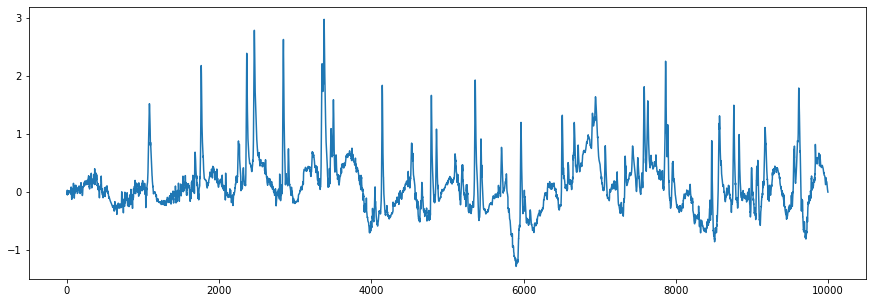

In [8]:
diff = V_test - test_V_pred.flatten()
plt.figure(figsize = (15,5))
plt.plot(diff.cpu().detach().numpy()[16000:26000])

(-1.0, 3.0)

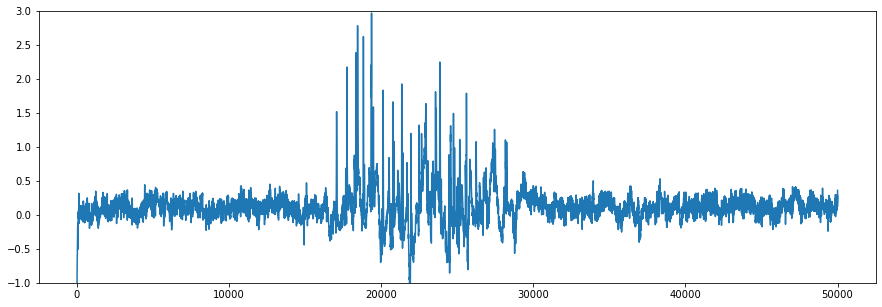

In [9]:
diff = V_test - test_V_pred.flatten()
plt.figure(figsize = (15,5))
plt.plot(diff.cpu().detach().numpy())
plt.ylim(-1,3)

In [11]:
torch.save(model.state_dict(), "/media/hdd01/sklee/CA1_clust4-60/gru_whole_h50.pt")
np.save("/media/hdd01/sklee/CA1_clust4-60/gru_whole_h50_output.npy", test_V_pred.cpu().detach().numpy().flatten())

In [5]:
model = BlindGRU(T_no, H_no, layer_no, in_no, device)
model.load_state_dict(torch.load("/media/hdd01/sklee/CA1_clust4-60/gru_blind_whole_h40.pt"))
model.eval()
model.to(device).float()



BlindGRU(
  (rnn): GRU(2200, 40, batch_first=True)
  (linear): Linear(in_features=40, out_features=1, bias=True)
)

In [9]:
V_resid = np.zeros((1000,50000))

for i in tnrange(1000):
    batch_E_neural = E_neural[i*50000:(i+1)*50000].toarray().reshape(1, batch_length, -1)
    batch_I_neural = I_neural[i*50000:(i+1)*50000].toarray().reshape(1, batch_length, -1)
    batch_E_neural = torch.from_numpy(batch_E_neural).float().to(device)
    batch_I_neural = torch.from_numpy(batch_I_neural).float().to(device)
    batch_V = V[i*50000:(i+1)*50000].to(device)
    batch_neural = torch.zeros(1, batch_length, in_no).to(device)
    batch_neural[:,:,:2000] = batch_E_neural
    batch_neural[:,:,2000:] = batch_I_neural
    
    V_pred, _ = model(batch_neural)
    resid = batch_V - V_pred.flatten()
    V_resid[i] = resid.cpu().detach().numpy()

<ipython-input-9-7b20be1180f4>:3: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(1000):


In [ ]:
np.save("/media/hdd01/sklee/CA1_clust4-60/V_resid_gru_blind_whole_h40.npy", V_resid.flatten())